In [116]:
ROOT = "/Users/gimli/cvr/data/zavity/trojan/GX010004.MP4"

In [117]:
import cv2
import subprocess
import matplotlib.pyplot as plt
import tempfile
import imageio.v3 as iio
import numpy as np
import os
from tqdm.auto import tqdm

In [118]:
# Read all frames into memory
vidcap = cv2.VideoCapture(ROOT)
success = True
frames = []
while success:
    success, frame = vidcap.read()
    if success:
        frames.append(frame)

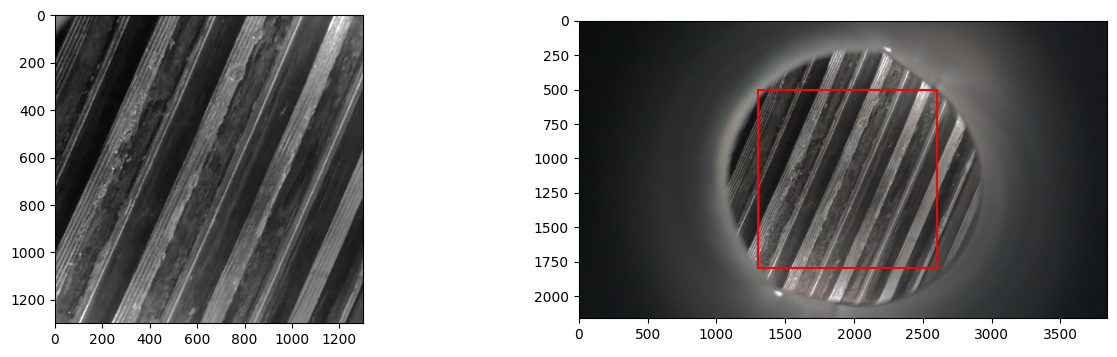

In [126]:
# Find out the proper crop
y1 = 500
y2 = 1800
x1 = 1300
x2 = 2600

plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.imshow(frames[120][y1:y2, x1:x2,0], cmap="gray")
ax = plt.subplot(122)
ax.imshow(frames[120])
ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color="red")
plt.show()

In [125]:
frame_angles = []
hists = []
for frame in tqdm(frames):
    undistorted =  frame[500:1800, 1300:2600,0]
    otsu_threshold, _ = cv2.threshold(undistorted, 0, 255, cv2.THRESH_OTSU)
    
    with tempfile.NamedTemporaryFile(suffix=".pgm", delete=False) as tmpfile:
        filename = tmpfile.name
        iio.imwrite(tmpfile.name, undistorted)  # this must be a grayscale image
        process = subprocess.Popen(
            ["devernay", tmpfile.name,
             "-t", "/dev/stdout",
             "-l", f"{otsu_threshold / 15}",
             "-h", f"{otsu_threshold / 3}",
             "-p", "/Users/gimli/sample.pdf",
             "-s", f"1",
             ], stdout=subprocess.PIPE)
        tmpfile.close()
    result = process.stdout.read().decode("utf-8")
    lines = result.split("\n")
    dev = []
    for line in lines:
        if line != "":
            x, y = line.split(' ')
            dev.append((float(x), float(y)))
    dev = np.array(dev)
    if len(dev) == 0:
        print("Something wrong happen")
    samples = 1000
    choice = np.random.randint(0, len(dev), samples)
    xx0 = np.matmul(dev[choice, 0].reshape(-1, 1), np.ones((1, len(choice))))
    yy0 = np.matmul(dev[choice, 1].reshape(-1, 1), np.ones((1, len(choice))))
    xx1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 0].reshape(1, -1))
    yy1 = np.matmul(np.ones((len(choice), 1)), dev[choice, 1].reshape(1, -1))
    valid = np.zeros_like(xx0, dtype=bool)
    valid[xx0 != xx1] = 1
    angles = np.zeros_like(xx0, np.float32)
    angles[xx0 == xx1] = np.pi / 2
    angles[valid] = np.arctan((yy0[valid] - yy1[valid]) / (xx0[valid] - xx1[valid])).reshape(-1)
    angles[np.eye(samples, dtype=bool)] = np.nan
    
    filtered = np.rad2deg(np.abs(angles[~np.isnan(angles)]))
    
    if filename is not None and os.path.exists(filename):
        os.remove(filename)
    
    counts, values = np.histogram(filtered, bins=samples)
    hists.append(filtered)
    frame_angles.append(values[np.argmax(counts)])

  0%|          | 0/1718 [00:00<?, ?it/s]

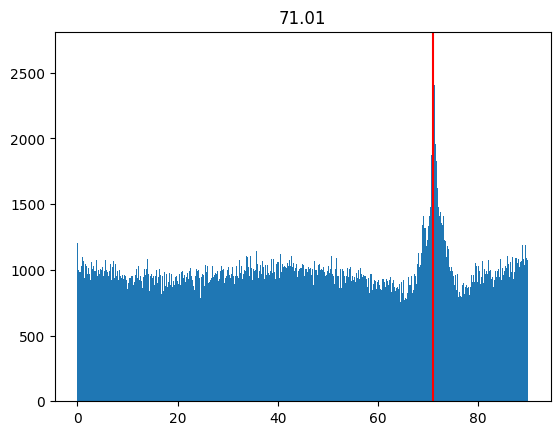

In [128]:
fid = 101
counts, values = np.histogram(hists[fid], bins=samples)
best = values[np.argmax(counts)]
plt.hist(hists[fid], bins=samples)
plt.axvline(best, color="red")
plt.title(best)
plt.show()

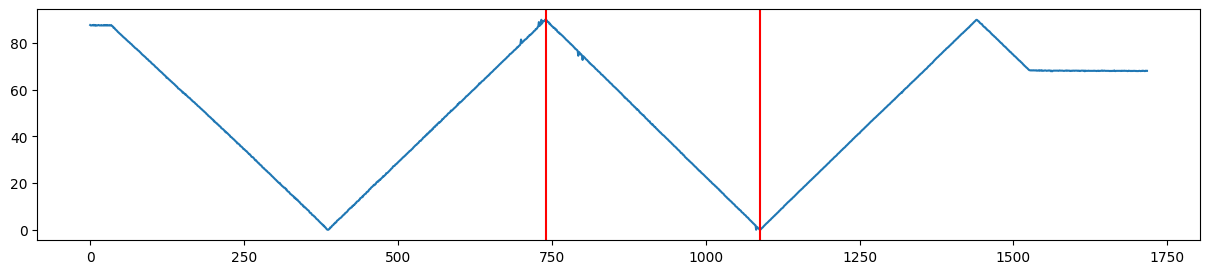

In [145]:
plt.figure(figsize=(15,3))
plt.plot(frame_angles)
plt.axvline(740, color="red")
plt.axvline(1088, color="red")
plt.show()

In [147]:
frame_angles = np.array(frame_angles)

In [148]:
np.where(np.array(frame_angles)==89.91)

(array([ 733,  739,  741, 1440]),)

In [157]:
fa = np.concatenate([frame_angles[34:386], -frame_angles[387:741], -180 + frame_angles[741: 1088], -180 - frame_angles[1088:1440]])
a, b = np.polyfit(np.arange(len(fa)), fa, 1)

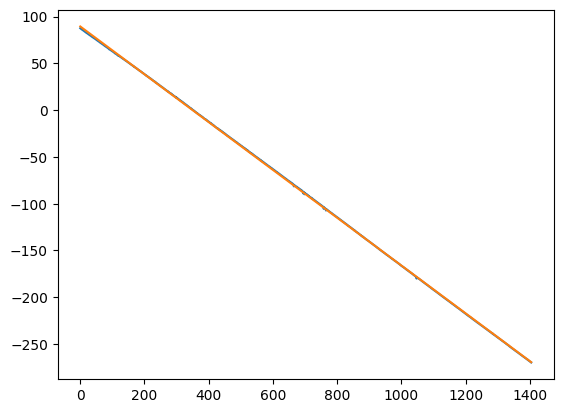

In [158]:
plt.plot(fa)
plt.plot([(a*x + b) for x in np.arange(len(fa))])
plt.show()

In [165]:
rot = -a
angle = 0
rotated = []
for frame in tqdm(frames[34: 1440]):
    rotate_matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1)    
    rotated_image = cv2.warpAffine( 
        src=frame, M=rotate_matrix, dsize=(frame.shape[1], frame.shape[0]))[y1: y2, x1:x2, 0]
    rotated.append(rotated_image)
    angle += rot

  0%|          | 0/1406 [00:00<?, ?it/s]

In [169]:
# Define the codec and create VideoWriter object
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('/Users/gimli/output.mp4', 
                      apiPreference=cv2.CAP_FFMPEG,
                      fourcc=cv2.VideoWriter_fourcc(*"H264"),
                      fps=10.0,
                      frameSize=(rotated[0].shape[1], rotated[0].shape[0]),
                        params=[
                            cv2.VIDEOWRITER_PROP_DEPTH,
                            cv2.CV_8U,
                            cv2.VIDEOWRITER_PROP_IS_COLOR,
                            0,  # false
                        ])
for frame in rotated:
    out.write(frame.astype(np.uint8))
out.release()


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
x265 [info]: frame I:     79, Avg QP:3.00  kb/s: 35429.66
x265 [info]: frame P:    159, Avg QP:3.00  kb/s: 32055.79
x265 [info]: frame B:    710, Avg QP:3.24  kb/s: 28712.10
x265 [info]: Weighted P-Frames: Y:0.6% UV:0.0%
x265 [info]: consecutive B-frames: 0.4% 0.0% 7.1% 85.7% 6.7% 

encoded 948 frames in 260.19s (3.64 fps), 29832.71 kb/s, Avg QP:3.18


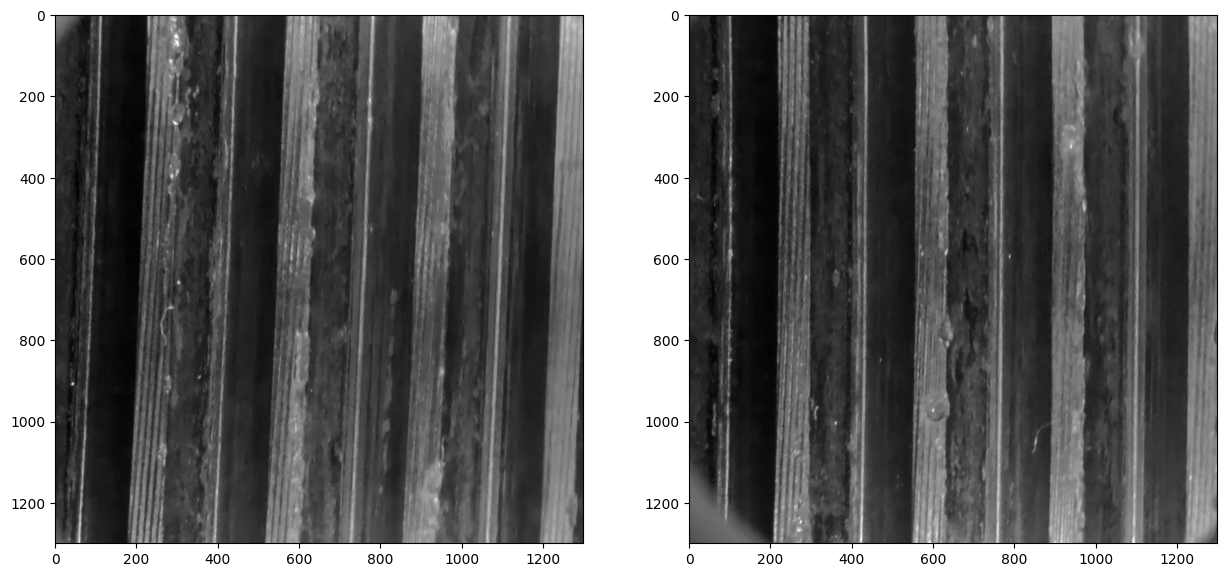

In [166]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(121)
ax.imshow(rotated[10], cmap="gray")
ax = plt.subplot(122)
ax.imshow(rotated[200], cmap="gray")
plt.show()

In [108]:
np.max(rotated)

np.uint8(151)

In [170]:
rot

np.float64(0.2556154607563937)